#Weight/BMI Prediction Based on Face Image


# Preparation
import module and load dataset    
Dataset is collected from       
Contains 900+ images with height and weight data

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 71kB/s 
     |████████████████████████████████| 3.0MB 35.0MB/s 
     |████████████████████████████████| 419kB 49.6MB/s 


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, json

from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.callbacks import ModelCheckpoint, Callback

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K

import tensorflow as tf

import cv2


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0-alpha0


In [0]:
#download the dataset
# data is collected from Internet

!rm -r ./dataset
!wget -qq https://www.dropbox.com/s/zgofhkeeu5ywato/dataset.zip
  
!unzip -qq dataset.zip
!rm dataset.zip

# download test image
!wget -qq https://www.dropbox.com/s/uxkorucs9arwfzf/brunomars.jpg
!wget -qq https://www.dropbox.com/s/giwov996mspe70e/yaoming.jpg


path = "./dataset/img/"
y=0
x=120
h=480
w=480

#crop&resize the image to 224*224
#also flip the images and add to dataset
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    img = cv2.imread(path+name)
    crop_img = img[y:y+h, x:x+w]
    resize_img = cv2.resize(crop_img, (224, 224), interpolation=cv2.INTER_CUBIC)
    
    flip_img = cv2.flip(resize_img, 1)  
    cv2.imwrite(path+name, resize_img)
    cv2.imwrite(path+"flip_"+name, flip_img)
    

rm: cannot remove './dataset': No such file or directory


# 1. Weight Prediction


Predict weight with a transfer-learning network based on VGG16

In [0]:
#read label file to construct a weight dictionary
weightmap = dict();

labels = open("./dataset/label.txt", "r")
for line in labels:
  idx = line.find('\t')
  if line[:idx] != "ID":
    filename = line[:idx]

    idx1 = line.rfind('\t')
    idx2 = line.rfind('\n')
    pound = float(line[idx1+1:idx2])
    weightmap[filename]=0.4536*pound
    
weightmap.items()

dict_items([('290060', 90.72), ('290079', 97.524), ('290098', 76.2048), ('290118', 86.184), ('290147', 56.7), ('290167', 68.04), ('290173', 62.1432), ('290182', 68.04), ('290201', 77.112), ('290206', 172.368), ('290248', 72.576), ('290250', 94.3488), ('290267', 97.524), ('290268', 91.6272), ('290273', 95.256), ('290302', 58.968), ('290310', 99.792), ('290328', 72.576), ('290339', 65.772), ('290350', 90.72), ('290352', 74.844), ('290376', 90.72), ('290384', 65.772), ('290391', 90.72), ('290392', 115.668), ('290394', 86.184), ('290418', 74.844), ('290434', 74.844), ('290503', 86.184), ('290504', 81.648), ('290505', 58.968), ('290566', 86.184), ('290619', 113.4), ('290635', 68.04), ('290637', 77.112), ('290641', 72.576), ('290642', 72.576), ('290667', 72.576), ('290685', 79.38), ('290691', 99.792), ('290695', 87.0912), ('290698', 122.472), ('290716', 102.06), ('290718', 81.648), ('290727', 108.864), ('290750', 113.4), ('290774', 117.4824), ('290805', 56.7), ('290817', 104.328), ('290882',

id: 290060
weight:90.72
image:
./dataset/img/290060.jpg


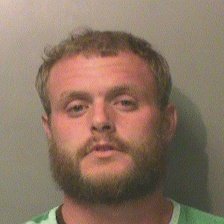

In [0]:
#display the first test sample
id = list(weightmap)[0]
print("id: "+id)
print("weight:" + str(weightmap[id]))

print("image:")
from IPython.display import Image
img_path = path+list(weightmap)[0]+".jpg"
print(img_path)
Image(img_path)

###**Construct dataframe**


classify data by weight into 3 classes:      
**light**: weight<70kg      
**normal-weighted**: 70kg<weight<86kg     
**heavy**: weight>86kg


In [0]:
# construct dataframe
import pandas as pd


data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in sorted(files):
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    
    idx = name.find('_')
    if idx==-1:
      num = name[:name.find('.')]
    else:
      num = name[idx+1:name.find('.')]
      
    weight = weightmap[num]
    if weight<70:
      data.append((filename, 0))
    elif weight<86:
      data.append((filename, 1))
    else:
      data.append((filename, 2))

df = pd.DataFrame(data, columns=['filename', 'class'])


#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head(20))
print(len(df))
df.dtypes

                                filename  class
0        /content/dataset/img/296530.jpg      0
1   /content/dataset/img/flip_290566.jpg      2
2        /content/dataset/img/292631.jpg      1
3        /content/dataset/img/295517.jpg      1
4   /content/dataset/img/flip_293757.jpg      0
5   /content/dataset/img/flip_291144.jpg      1
6        /content/dataset/img/295603.jpg      2
7   /content/dataset/img/flip_295067.jpg      1
8   /content/dataset/img/flip_296346.jpg      0
9        /content/dataset/img/292713.jpg      1
10       /content/dataset/img/290098.jpg      1
11  /content/dataset/img/flip_295345.jpg      2
12       /content/dataset/img/293574.jpg      0
13       /content/dataset/img/296286.jpg      0
14  /content/dataset/img/flip_295237.jpg      1
15       /content/dataset/img/294117.jpg      2
16  /content/dataset/img/flip_290635.jpg      0
17  /content/dataset/img/flip_293467.jpg      0
18  /content/dataset/img/flip_294916.jpg      0
19       /content/dataset/img/295555.jpg

filename    object
class        int64
dtype: object

In [0]:
# Split into train and validation sets
train_set_percentage = .9

df_val = df[int(len(df)*train_set_percentage):]
df = df[:int(len(df)*train_set_percentage)]

# shuffle 
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it to a fixed shape.
img_rows, img_cols = 224,224
num_classes = 3
batch_size = 8

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset

<BatchDataset shapes: ((8, 224, 224, 3), (8, 3)), types: (tf.float32, tf.float32)>

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(5000)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)
valid_dataset

<BatchDataset shapes: ((8, 224, 224, 3), (8, 3)), types: (tf.float32, tf.float32)>

In [0]:
train_steps = int(len(df)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)
epochs = 10

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 212
val steps: 23


### Construct model

In [0]:
#load base model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling=None)

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

x = Dense(32, activation='relu')(x)

x = Dropout(0.3)(x)

predictions = Dense(3, activation='softmax')(x)


In [0]:
for layer in base_model.layers:
    if layer.name[:layer.name.find('_')]!="block5":
      layer.trainable = False


In [0]:
model = Model(inputs=base_model.input, outputs=predictions)
opt = tf.keras.optimizers.Adam(lr=0.0001)

model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
#create checkpoint callback
!mkdir checkpoints
checkpoint = ModelCheckpoint('./checkpoints/new_weights_weight_predict.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

### Train model

In [0]:
# train the model with validation 
history = model.fit( train_dataset, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks = [checkpoint])

Epoch 1/10
211/212 [============================>.] - ETA: 0s - loss: 1.1776 - accuracy: 0.3709
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to ./checkpoints/new_weights_weight_predict.hdf5
212/212 [==============================] - 33s 154ms/step - loss: 1.1770 - accuracy: 0.3715 - val_loss: 1.0664 - val_accuracy: 0.5000
Epoch 2/10
211/212 [============================>.] - ETA: 0s - loss: 1.0592 - accuracy: 0.4100
Epoch 00002: val_accuracy did not improve from 0.50000
212/212 [==============================] - 19s 89ms/step - loss: 1.0593 - accuracy: 0.4092 - val_loss: 1.0491 - val_accuracy: 0.3696
Epoch 3/10
211/212 [============================>.] - ETA: 0s - loss: 1.0121 - accuracy: 0.4532
Epoch 00003: val_accuracy did not improve from 0.50000
212/212 [==============================] - 19s 90ms/step - loss: 1.0109 - accuracy: 0.4558 - val_loss: 0.9912 - val_accuracy: 0.4946
Epoch 4/10
211/212 [============================>.] - ETA: 0s - loss: 0.9660 - accu

###Display result

In [0]:
#plot function
def plot_train(hist):
    h = hist.history
    if 'accuracy' in h:
        meas='accuracy'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

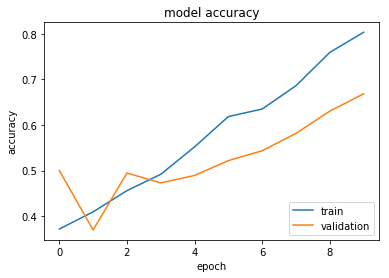

In [0]:
plot_train(history)

In [0]:
#load weights from checkpoint
model.load_weights("./checkpoints/new_weights_weight_predict.hdf5")

In [0]:
from IPython.display import Image
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

def predict_weight(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  print('Input image shape:', x.shape) 

  preds = model.predict(x)
  print('Predicted:', preds)
  if preds[0][0] == preds[0].max():
    print("This person is light.")
  elif preds[0][1] == preds[0].max():
    print("This person is normal-weighted.")
  else:
    print("This person is heavy.")
  Image(img_path)


Using TensorFlow backend.


###Try some celebrity images

Bruno Mars: actual weight : 67kg (light)

Input image shape: (1, 224, 224, 3)
Predicted: [[0.50999856 0.4618308  0.02817066]]
This person is light.


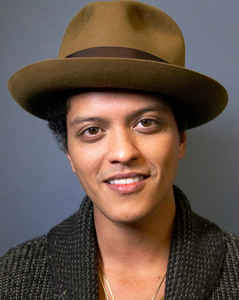

In [0]:
img_path = "brunomars.jpg"
predict_weight(img_path)
Image(img_path)

Yao Ming: actual weight: 141kg (heavy)

Input image shape: (1, 224, 224, 3)
Predicted: [[7.6064130e-04 8.4530301e-02 9.1470903e-01]]
This person is heavy.


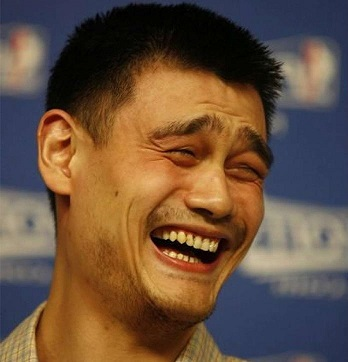

In [0]:
img_path = "yaoming.jpg"
predict_weight(img_path)
Image(img_path)

# BMI
Since weight depend a lot on height data, it's not an accurate way to measure body fat level. Therefore we choose BMI as another metric.       
BMI = weight(kg) / (height(m) * height(m))

**light**: BMI<22     
**normal-weighted**: 22<BMI<27       
**heavy**:BMI>27

In [0]:
#read label file to construct a weight dict
heightmap = dict();

labels = open("./dataset/label.txt", "r")
for line in labels:
  idx = line.find('\t')
  if line[:idx] != "ID":
    filename = line[:idx]

    idx1 = line.find('\"')
    inch = float(line[idx1-2:idx1])
    idx2 = line.find('\'')
    feet = float(line[idx2-1:idx2])
    heightmap[filename]= feet*0.3048 + inch*0.024  

heightmap.items()

dict_items([('290060', 1.8288000000000002), ('290079', 1.6440000000000001), ('290098', 1.716), ('290118', 1.716), ('290147', 1.6440000000000001), ('290167', 1.572), ('290173', 1.62), ('290182', 1.596), ('290201', 1.8528000000000002), ('290206', 1.8768000000000002), ('290248', 1.74), ('290250', 1.8768000000000002), ('290267', 1.764), ('290268', 1.692), ('290273', 1.8768000000000002), ('290302', 1.6680000000000001), ('290310', 1.74), ('290328', 1.62), ('290339', 1.62), ('290350', 1.764), ('290352', 1.764), ('290376', 1.692), ('290384', 1.62), ('290391', 1.788), ('290392', 1.9008000000000003), ('290394', 1.788), ('290418', 1.716), ('290434', 1.788), ('290503', 1.764), ('290504', 1.6440000000000001), ('290505', 1.692), ('290566', 1.764), ('290619', 1.764), ('290635', 1.6680000000000001), ('290637', 1.692), ('290641', 1.692), ('290642', 1.692), ('290667', 1.764), ('290685', 1.74), ('290691', 1.9008000000000003), ('290695', 1.9008000000000003), ('290698', 1.9248000000000003), ('290716', 1.78

###Construct dataframe

In [0]:

dataBMI = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in sorted(files):
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    
    idx = name.find('_')
    if idx==-1:
      num = name[:name.find('.')]
    else:
      num = name[idx+1:name.find('.')]
    
    weight = weightmap[num]
    #print(weight)
    height = heightmap[num]
    #print(height)
    BMI = weight/height/height
    #print(BMI)
    #if weight!=0:
    #data.append((filename, weight))
    if BMI<22:
      dataBMI.append((filename, 0))
    elif BMI<27:
      dataBMI.append((filename, 1))
    else:
      dataBMI.append((filename, 2))

dfBMI = pd.DataFrame(dataBMI, columns=['filename', 'class'])


#shuffle
dfBMI = dfBMI.sample(frac=1).reset_index(drop=True)

print(dfBMI.head(20))
print(len(dfBMI))
dfBMI.dtypes

                                filename  class
0        /content/dataset/img/295518.jpg      1
1        /content/dataset/img/294907.jpg      2
2        /content/dataset/img/296175.jpg      1
3        /content/dataset/img/295380.jpg      2
4        /content/dataset/img/294584.jpg      2
5        /content/dataset/img/296314.jpg      1
6   /content/dataset/img/flip_294516.jpg      0
7        /content/dataset/img/295237.jpg      1
8        /content/dataset/img/294611.jpg      0
9   /content/dataset/img/flip_294055.jpg      2
10       /content/dataset/img/295437.jpg      1
11  /content/dataset/img/flip_293236.jpg      0
12  /content/dataset/img/flip_296302.jpg      1
13  /content/dataset/img/flip_294150.jpg      0
14  /content/dataset/img/flip_294975.jpg      1
15       /content/dataset/img/292063.jpg      1
16       /content/dataset/img/293898.jpg      2
17  /content/dataset/img/flip_294960.jpg      1
18  /content/dataset/img/flip_296224.jpg      1
19  /content/dataset/img/flip_296509.jpg

filename    object
class        int64
dtype: object

In [0]:
# Split into train and validation sets

dfBMI_val = dfBMI[int(len(df)*train_set_percentage):]
dfBMI = dfBMI[:int(len(df)*train_set_percentage)]

# shuffle 
dfBMI = dfBMI.sample(frac=1).reset_index(drop=True)
dfBMI_val = dfBMI_val.sample(frac=1).reset_index(drop=True)

In [0]:
train_datasetBMI = tf.data.Dataset.from_tensor_slices((tf.cast(dfBMI['filename'].values, tf.string),
                                                    tf.cast(dfBMI['class'].values, tf.int32) ))
train_datasetBMI = train_datasetBMI.map(_parse_function)
train_datasetBMI = train_datasetBMI.shuffle(5000)
train_datasetBMI = train_datasetBMI.repeat()
train_datasetBMI = train_datasetBMI.batch(batch_size, drop_remainder=True)
train_datasetBMI

<BatchDataset shapes: ((8, 224, 224, 3), (8, 3)), types: (tf.float32, tf.float32)>

In [0]:
valid_datasetBMI = tf.data.Dataset.from_tensor_slices((tf.cast(dfBMI_val['filename'].values, tf.string),
                                                    tf.cast(dfBMI_val['class'].values, tf.int32) ))
valid_datasetBMI = valid_datasetBMI.map(_parse_function)
valid_datasetBMI = valid_datasetBMI.shuffle(5000)
valid_datasetBMI = valid_datasetBMI.repeat()
valid_datasetBMI = valid_datasetBMI.batch(batch_size, drop_remainder=True)
valid_datasetBMI

<BatchDataset shapes: ((8, 224, 224, 3), (8, 3)), types: (tf.float32, tf.float32)>

###Construct model

In [0]:
modelBMI = Model(inputs=base_model.input, outputs=predictions)

modelBMI.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
modelBMI.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
checkpointBMI = ModelCheckpoint('./checkpoints/new_weights_BMI.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

###Train model

In [0]:
historyBMI = modelBMI.fit( train_datasetBMI, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_datasetBMI,
                   validation_steps = val_steps,
                   callbacks = [checkpointBMI])

Epoch 1/10
211/212 [============================>.] - ETA: 0s - loss: 0.7898 - accuracy: 0.6481
Epoch 00001: val_accuracy improved from -inf to 0.63587, saving model to ./checkpoints/new_weights_BMI.hdf5
212/212 [==============================] - 31s 146ms/step - loss: 0.7881 - accuracy: 0.6492 - val_loss: 0.7392 - val_accuracy: 0.6359
Epoch 2/10
211/212 [============================>.] - ETA: 0s - loss: 0.5587 - accuracy: 0.7547
Epoch 00002: val_accuracy improved from 0.63587 to 0.72283, saving model to ./checkpoints/new_weights_BMI.hdf5
212/212 [==============================] - 20s 97ms/step - loss: 0.5573 - accuracy: 0.7553 - val_loss: 0.7697 - val_accuracy: 0.7228
Epoch 3/10
211/212 [============================>.] - ETA: 0s - loss: 0.4650 - accuracy: 0.8063
Epoch 00003: val_accuracy did not improve from 0.72283
212/212 [==============================] - 20s 94ms/step - loss: 0.4661 - accuracy: 0.8054 - val_loss: 0.8463 - val_accuracy: 0.6793
Epoch 4/10
211/212 [==================

###Display result

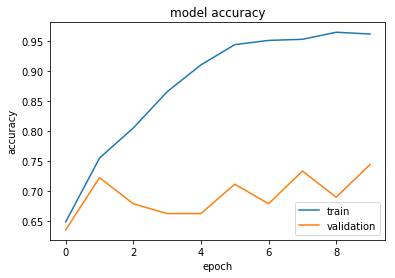

In [0]:
plot_train(historyBMI)

In [0]:
modelBMI.load_weights("./checkpoints/new_weights_BMI.hdf5")

In [0]:
def predict_BMI(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  print('Input image shape:', x.shape) 

  preds = modelBMI.predict(x)
  print('Predicted:', preds)
  if preds[0][0] == preds[0].max():
    print("This person is light.")
  elif preds[0][1] == preds[0].max():
    print("This person is normal-weighted.")
  else:
    print("This person is heavy.")
  Image(img_path)

### Try celebrity images

Bruno Mars: actual weight : 67kg, actual height: 1.63m, BMI: 25.2 (normal-weighted)

Input image shape: (1, 224, 224, 3)
Predicted: [[7.3952878e-01 2.6034662e-01 1.2457340e-04]]
This person is light.


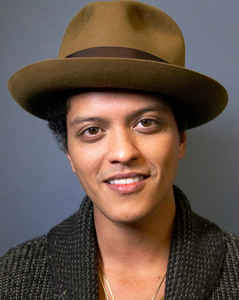

In [0]:
img_path = "brunomars.jpg"
predict_BMI(img_path)
Image(img_path)

Yao ming: actual weight : 141kg, actual height: 2.26m, BMI: 27.6 (heavy)

Input image shape: (1, 224, 224, 3)
Predicted: [[1.2789929e-05 6.4104535e-02 9.3588263e-01]]
This person is heavy.


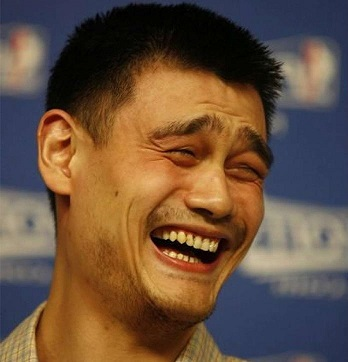

In [0]:
img_path = "yaoming.jpg"
predict_weight(img_path)
Image(img_path)